In [1]:
import math
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, average_precision_score, f1_score, precision_score, fbeta_score
from sklearn.linear_model import LogisticRegression

from imblearn.combine import SMOTEENN
from scipy.stats import zscore

import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING) 

import shap
shap.initjs()

RANDOM_STATE=20

C:\Users\hewtu\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from utils import *

In [3]:
df_train = pd.read_csv("train.csv")
df_valid = pd.read_csv("valid.csv")
df_test = pd.read_csv("test.csv")

In [4]:
def log_objective_recall(trial):
    X_train, y_train, X_valid, y_valid, X_test, y_test = with_resampling(df_train, df_valid, df_test)
    
    params = {
        'tol' : trial.suggest_float('tol' , 1e-6 , 1e-3),
        'C' : trial.suggest_float("C", 1e-2, 1),
        'fit_intercept' : trial.suggest_categorical('fit_intercept' , [True, False]),
        'solver' : trial.suggest_categorical('solver' , ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']),
    }
    
    model = LogisticRegression(**params, max_iter=10000, random_state=RANDOM_STATE)
    model.fit(X_train , y_train)
    
    predictions = model.predict(X_valid)
    
    return recall_score(y_valid, predictions)

In [5]:
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial : log_objective_recall(trial) ,n_trials=50)
print("Number of finished trials: ", len(study.trials))

Number of finished trials:  50


In [6]:
study.best_trial

FrozenTrial(number=22, values=[0.8880597014925373], datetime_start=datetime.datetime(2022, 11, 13, 17, 45, 17, 173459), datetime_complete=datetime.datetime(2022, 11, 13, 17, 45, 18, 746136), params={'tol': 0.0008277905959250614, 'C': 0.05919804639334242, 'fit_intercept': False, 'solver': 'newton-cg'}, distributions={'tol': FloatDistribution(high=0.001, log=False, low=1e-06, step=None), 'C': FloatDistribution(high=1.0, log=False, low=0.01, step=None), 'fit_intercept': CategoricalDistribution(choices=(True, False)), 'solver': CategoricalDistribution(choices=('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'))}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=22, state=TrialState.COMPLETE, value=None)

In [7]:
best_params = study.best_trial.params
best_params

{'tol': 0.0008277905959250614,
 'C': 0.05919804639334242,
 'fit_intercept': False,
 'solver': 'newton-cg'}

In [8]:
X_train, y_train, X_valid, y_valid, X_test, y_test = with_resampling(df_train, df_valid, df_test)

clf = LogisticRegression(**best_params, max_iter=10000, random_state=RANDOM_STATE)

predictions = obtain_predictions(clf, X_train, y_train, X_valid, y_valid)
get_scores(y_valid, predictions)

Precision: 8.27%
Accuracy: 41.06%
Recall: 88.81%
F1: 0.15
Fbeta: 0.12
ROC AUC: 0.63
PR AUC: 0.08


In [9]:
def log_objective_fbeta(trial):
    X_train, y_train, X_valid, y_valid, X_test, y_test = with_resampling(df_train, df_valid, df_test)
    
    params = {
        'tol' : trial.suggest_float('tol' , 1e-6 , 1e-3),
        'C' : trial.suggest_float("C", 1e-2, 1),
        'fit_intercept' : trial.suggest_categorical('fit_intercept' , [True, False]),
        'solver' : trial.suggest_categorical('solver' , ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']),
    }
    
    model = LogisticRegression(**params, max_iter=10000, random_state=RANDOM_STATE)
    model.fit(X_train , y_train)
    
    predictions = model.predict(X_valid)
    
    return fbeta_score(y_valid, predictions, beta=2)

In [10]:
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial : log_objective_fbeta(trial), n_trials=50)
print("Number of finished trials: ", len(study.trials))

Number of finished trials:  50


In [11]:
study.best_trial

FrozenTrial(number=41, values=[0.29843196762771873], datetime_start=datetime.datetime(2022, 11, 13, 17, 47, 14, 274216), datetime_complete=datetime.datetime(2022, 11, 13, 17, 47, 15, 892508), params={'tol': 0.00032116302163958223, 'C': 0.05472848709718754, 'fit_intercept': False, 'solver': 'newton-cg'}, distributions={'tol': FloatDistribution(high=0.001, log=False, low=1e-06, step=None), 'C': FloatDistribution(high=1.0, log=False, low=0.01, step=None), 'fit_intercept': CategoricalDistribution(choices=(True, False)), 'solver': CategoricalDistribution(choices=('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'))}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=41, state=TrialState.COMPLETE, value=None)

In [12]:
best_params = study.best_trial.params
best_params

{'tol': 0.00032116302163958223,
 'C': 0.05472848709718754,
 'fit_intercept': False,
 'solver': 'newton-cg'}

In [13]:
X_train, y_train, X_valid, y_valid, X_test, y_test = with_resampling(df_train, df_valid, df_test)

clf = LogisticRegression(**best_params, max_iter=10000, random_state=RANDOM_STATE)

predictions = obtain_predictions(clf, X_train, y_train, X_valid, y_valid)
get_scores(y_valid, predictions)

Precision: 8.19%
Accuracy: 40.88%
Recall: 88.06%
F1: 0.15
Fbeta: 0.12
ROC AUC: 0.63
PR AUC: 0.08


Estimating transforms: 100%|██████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 102.69it/s]


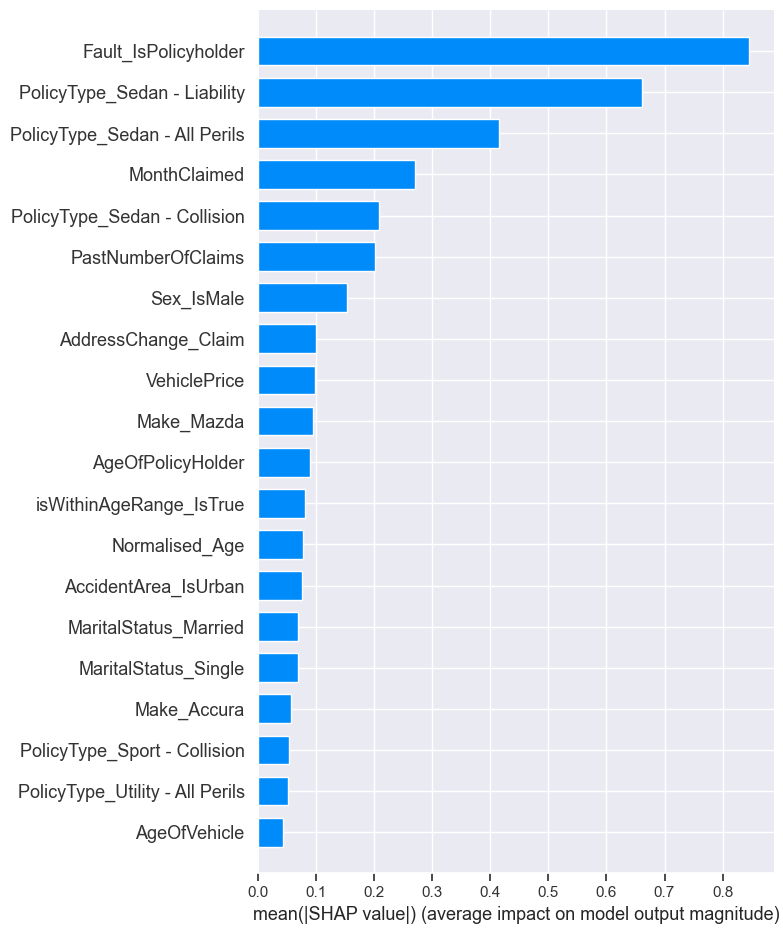

In [14]:
explainer = shap.LinearExplainer(
    clf, 
    masker=shap.maskers.Impute(data=X_train),
    method='linear',
    feature_names=df_train.drop('FraudFound_P', axis=1).columns,
    random_state=RANDOM_STATE
)
shap_values = explainer(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

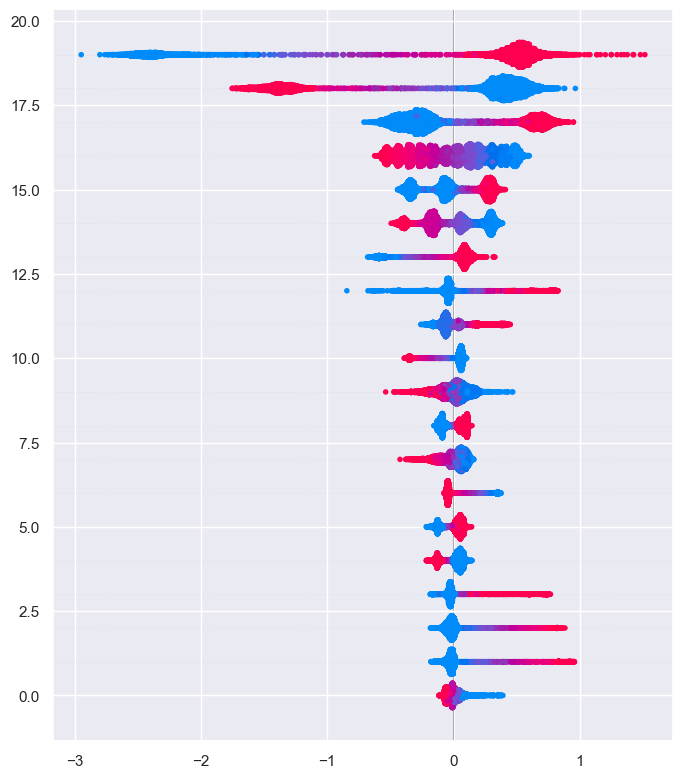

In [15]:
features  = df_train.drop('FraudFound_P', axis=1).columns.tolist()
shap.summary_plot(shap_values, X_train, features)